In [1]:
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('Dummy.csv')

In [3]:
start = df.iloc[0]['C1']

In [4]:
df.head()

,C1,C2
0,1978-02,5985.7
1,1978-03,6040.6
2,1978-04,6054.2
3,1978-05,6038.3
4,1978-06,6031.3


In [5]:
print('input prediction horizon')

input prediction horizon


In [6]:
horizon = int(input())

40


## Datetime Indexing

In [7]:
df['C1'] = pd.to_datetime(df.C1)
#'Time', 'General', 'Long Date','Number'various Excel datatypes can all be typecasted to datetime64[ns] type 


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
C1    54 non-null datetime64[ns]
C2    44 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 944.0 bytes


In [9]:
df.set_index('C1',inplace=True)

In [10]:
df.head()

,C2
C1,
1978-02-01,5985.7
1978-03-01,6040.6
1978-04-01,6054.2
1978-05-01,6038.3
1978-06-01,6031.3


## Time-Series Exploration/Plotting

In [11]:
pd.infer_freq(df.index)
#Inferring the frequency of the given time series

'MS'

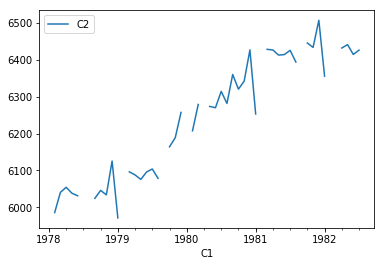

In [12]:
df.plot()

## Imputing for missing values & Seasonal Decomposition 

<Figure size 432x288 with 0 Axes>

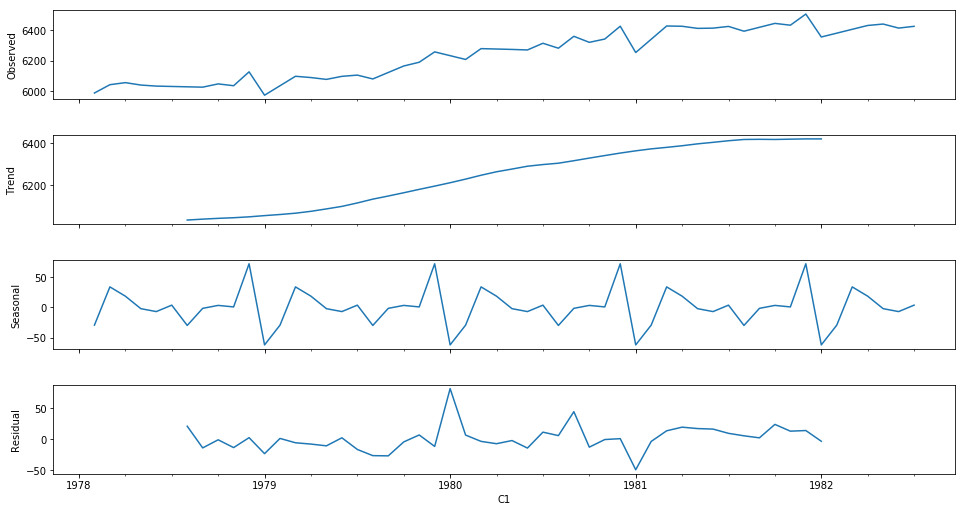

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['C2'].interpolate(method = 'linear'))
#Seasonal_decompose with statsmodels doesnt handle missing values hence the interpolation
#We can use various forms of methods to interpolate for missing values (linear, nearest, spline, polynomial...) 
#Linear interpolation on seasonal loess decomposed data using stldecompose 0.0.3 package or using Kalman filters for imputation
#using (SciPy package) is likely to be a better alternative for Time series with a disctinct seasonal component.
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)
df['C2'].interpolate(method = 'linear', inplace=True)

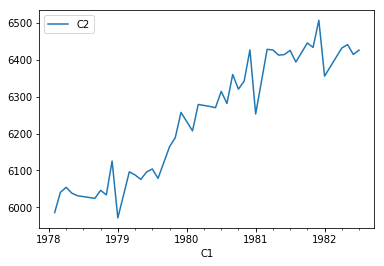

In [14]:
df.plot()

In [15]:
trend = decomposition.trend #Trend component isolated

In [16]:
seasonality = decomposition.seasonal #Seasonal component isolated

## Model Selection
#### 1) Holt - Winters
#### 2) SARIMAX


In [17]:
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA 

### HOLT WINTERS

389.28483337412683
373.9975800364683


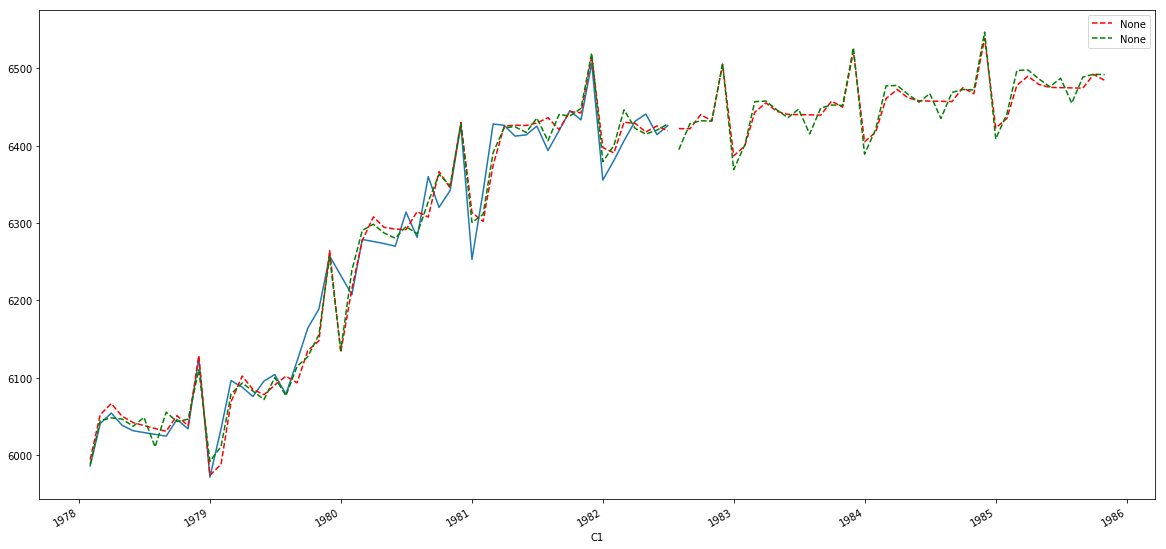

In [18]:
#warnings.filterwarnings("ignore")
plt.plot(df['C2'].index,df['C2'])
fit1 = ExponentialSmoothing(df['C2'], seasonal_periods=12, trend='add', seasonal='add', freq= pd.infer_freq(df.index)).fit(use_boxcox=True)
fit2 = ExponentialSmoothing(df['C2'], seasonal_periods=12, trend='add', seasonal='mul', freq= pd.infer_freq(df.index)).fit(use_boxcox=True)

fit1.fittedvalues.plot(style='--', color='red')
fit2.fittedvalues.plot(style='--', color='green')

print(fit1.aic)
print(fit2.aic)


fit1.forecast(horizon).plot(style='--', color='red', legend=True, figsize=(20,10))
fit2.forecast(horizon).plot(style='--', color='green', legend=True)
test_1 = fit1.forecast(horizon)
test_2 = fit2.forecast(horizon)

### SARIMAX

In [19]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#### Grid Searching for optimal SARIMAX parameters that minimize the AIC values for the fitted model

In [20]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1078.8558832722601
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:790.2625534239565
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:518.7031361748648
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1134.7937428670182
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:480.6263685059816
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:458.79608871844835
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:366.01611509046296
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:355.25453957746953
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1023.6387765126685
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:783.5641806025977
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:477.5766821496144
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1111.2565604017202
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:465.64824699293035
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:432.4546433849454
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:356.09704357366235
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:319.46213988630643
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:565.7707308533267
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:421.743957070346
A

In [21]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1,1,1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6283      0.380     -1.654      0.098      -1.373       0.116
ma.L1          0.2315      0.509      0.454      0.649      -0.767       1.230
ar.S.L12      -0.7128      0.095     -7.483      0.000      -0.900      -0.526
sigma2       935.9558    263.798      3.548      0.000     418.922    1452.990


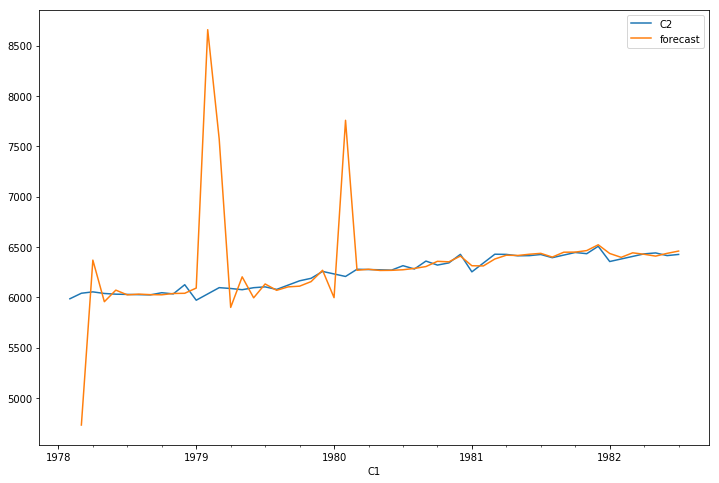

In [22]:
df['forecast'] = results.predict (start = 1, end = 54)  
df[['C2','forecast']].plot(figsize=(12,8))

In [23]:
from pandas.tseries.offsets import DateOffset

In [24]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,horizon) ]

In [25]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [26]:
future_df = pd.concat([df,future_dates_df])

In [27]:
future_df.head()

,C2,forecast
1978-02-01,5985.7,NaN
1978-03-01,6040.6,4732.006961
1978-04-01,6054.2,6369.388733
1978-05-01,6038.3,5956.465828
1978-06-01,6031.3,6071.482356


In [28]:
future_df['forecast'] = results.predict(start = 53, end = 53+horizon, dynamic= True)  


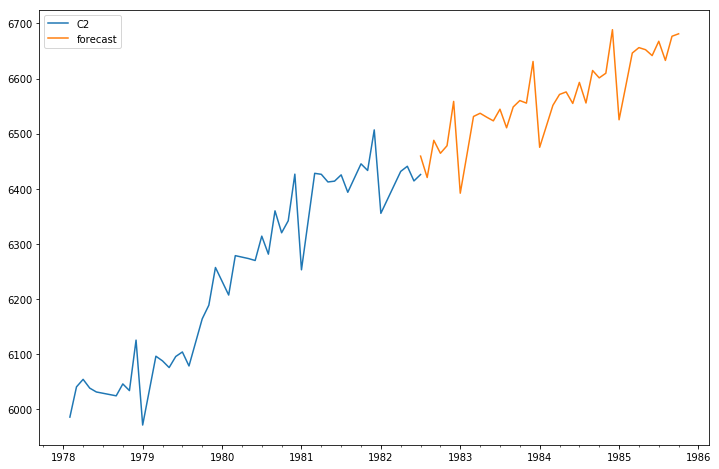

In [29]:
future_df[['C2', 'forecast']].plot(figsize=(12, 8)) 

## RESULTS

In [30]:
#Predictions using Additive Holt-Winter
test_1

1982-08-01    6422.135002
1982-09-01    6421.803992
1982-10-01    6440.103428
1982-11-01    6432.152251
1982-12-01    6505.357619
1983-01-01    6386.860793
1983-02-01    6399.432755
1983-03-01    6443.315904
1983-04-01    6455.334218
1983-05-01    6444.463776
1983-06-01    6440.517649
1983-07-01    6440.184863
1983-08-01    6439.854751
1983-09-01    6439.527311
1983-10-01    6457.630746
1983-11-01    6449.764398
1983-12-01    6522.207661
1984-01-01    6404.966036
1984-02-01    6417.399416
1984-03-01    6460.809093
1984-04-01    6472.700460
1984-05-01    6461.944790
1984-06-01    6458.040561
1984-07-01    6457.711314
1984-08-01    6457.384714
1984-09-01    6457.060758
1984-10-01    6474.972861
1984-11-01    6467.189330
1984-12-01    6538.888145
1985-01-01    6422.872123
1985-02-01    6435.170319
1985-03-01    6478.117886
1985-04-01    6489.885290
1985-05-01    6479.241696
1985-06-01    6475.378375
1985-07-01    6475.052584
1985-08-01    6474.729412
1985-09-01    6474.408857
1985-10-01  

In [31]:
#Predictions using Multiplicative Holt-Winter
test_2

1982-08-01    6394.918722
1982-09-01    6428.457587
1982-10-01    6432.263679
1982-11-01    6431.756673
1982-12-01    6506.221279
1983-01-01    6368.935430
1983-02-01    6400.904125
1983-03-01    6456.971293
1983-04-01    6457.690557
1983-05-01    6446.382978
1983-06-01    6436.169091
1983-07-01    6447.203472
1983-08-01    6415.165951
1983-09-01    6448.784539
1983-10-01    6452.576254
1983-11-01    6452.041306
1983-12-01    6526.714182
1984-01-01    6388.969969
1984-02-01    6421.013214
1984-03-01    6477.230351
1984-04-01    6477.925764
1984-05-01    6466.556757
1984-06-01    6456.285019
1984-07-01    6467.328023
1984-08-01    6435.164827
1984-09-01    6468.862481
1984-10-01    6472.640313
1984-11-01    6472.078080
1984-12-01    6546.957002
1985-01-01    6408.760329
1985-02-01    6440.877529
1985-03-01    6497.243121
1985-04-01    6497.915285
1985-05-01    6486.485907
1985-06-01    6476.157329
1985-07-01    6487.209158
1985-08-01    6454.922114
1985-09-01    6488.698184
1985-10-01  

In [32]:
#Predictions using SARIMAX
future_df['forecast'].loc['1982-08-01':]

1982-08-01    6420.505500
1982-09-01    6487.988886
1982-10-01    6464.485282
1982-11-01    6478.176228
1982-12-01    6558.613410
1983-01-01    6392.019550
1983-02-01    6461.315452
1983-03-01    6531.256723
1983-04-01    6537.101947
1983-05-01    6529.962829
1983-06-01    6523.331311
1983-07-01    6544.427816
1983-08-01    6510.728850
1983-09-01    6548.514781
1983-10-01    6560.146178
1983-11-01    6555.530136
1983-12-01    6631.089831
1984-01-01    6475.328858
1984-02-01    6513.309589
1984-03-01    6551.478101
1984-04-01    6571.238021
1984-05-01    6575.817420
1984-06-01    6554.951720
1984-07-01    6593.108284
1984-08-01    6555.756018
1984-09-01    6614.710969
1984-10-01    6601.297372
1984-11-01    6609.730953
1984-12-01    6688.767408
1985-01-01    6525.284538
1985-02-01    6585.587367
1985-03-01    6646.404164
1985-04-01    6656.245398
1985-05-01    6652.471596
1985-06-01    6641.752315
1985-07-01    6667.748116
1985-08-01    6632.999998
1985-09-01    6676.865232
1985-10-01  